In [ ]:
!pip install pyDOE

  Preparing metadata (setup.py) ... done
  Created wheel for pyDOE: filename=pyDOE-0.3.8-py3-none-any.whl size=18170 sha256=a1dd77eb0c59f32e9d92c7c241af9b3f5e3f97393ed02b9fb4e4455e1b64ba5e
  Stored in directory: /root/.cache/pip/wheels/ce/b6/d7/c6b64746dba6433c593e471e0ac3acf4f36040456d1d160d17
Successfully built pyDOE


In [ ]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import Dataset, DataLoader, ConcatDataset

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pyDOE import lhs

from IPython.display import clear_output
import time
from datetime import datetime, timedelta
import gc

import sys
import os

import scipy.io
from scipy.interpolate import griddata

np.random.seed(0)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
%cd /content/drive/MyDrive/CursoPINN-CEIA-UBA/Modulo6

/content/drive/MyDrive/CursoPINN-CEIA-UBA/Modulo6


# Burger's equation

The governing equations are:
$$u_t + uu_x - \nu u_{xx} = 0$$
$$u(0,x)=-\sin(\pi x)$$
$$u(-1, t)=u(1,t)=0$$

# Problem data

In [ ]:
# Load data from .mat file
data = scipy.io.loadmat('./burgers_shock.mat')

t = data['t'].flatten()[:, None]
x = data['x'].flatten()[:, None]
Exact = np.real(data['usol']).T
X, T = np.meshgrid(x, t)
X_star = np.hstack((X.flatten()[:, None], T.flatten()[:, None]))
u_star = Exact.flatten()[:, None]

# Exact solution

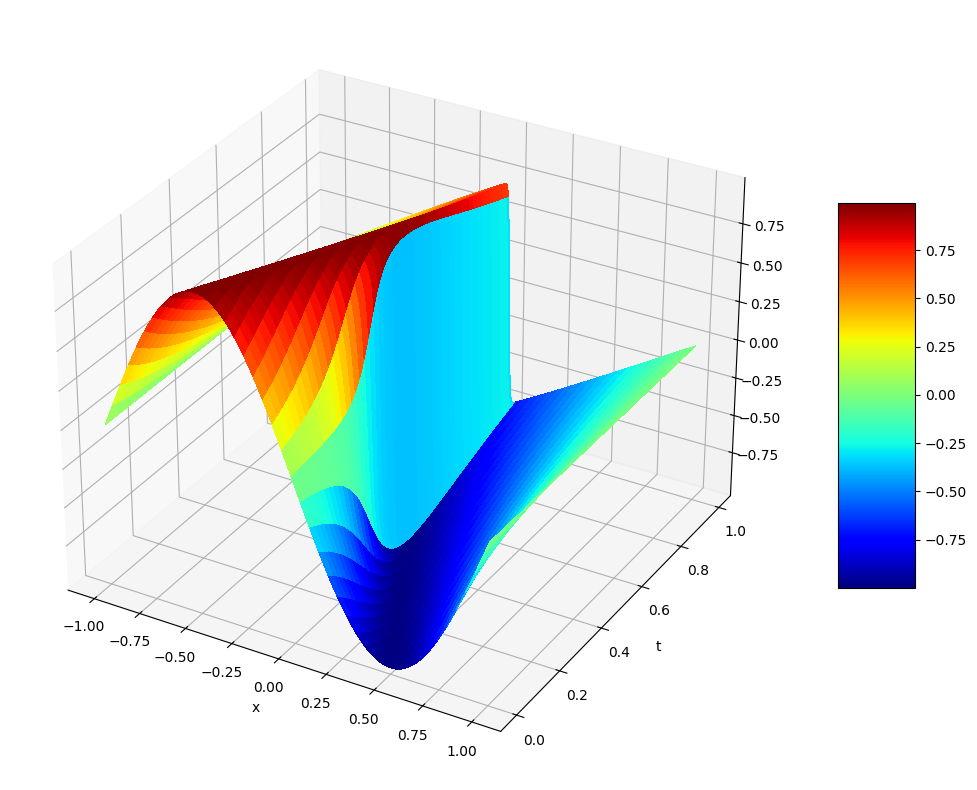

In [ ]:
# Plot the exact solution
fig = plt.figure(figsize=(15, 10))
ax = fig.add_subplot(111, projection = '3d')
#ax.view_init(elev=20, azim=-90)
surf1 = ax.plot_surface(X, T, Exact, cmap=cm.jet, linewidth=0, antialiased=False)
fig.colorbar(surf1, shrink=0.5, aspect=5)
plt.xlabel('x')
plt.ylabel('t')
plt.show()

# Datasets (collocation points and labelled data points)

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        features = self.X[idx, :]
        target = self.y[idx, :]
        return features, target

In [ ]:
# Domain bounds
lb = torch.from_numpy(X_star.min(0)).to(torch.float32)
ub = torch.from_numpy(X_star.max(0)).to(torch.float32)

# Initial Condition
xx1 = np.hstack((X[0:1, :].T, T[0:1, :].T))
uu1 = Exact[0:1, :].T

# Boundary condition -1
xx2 = np.hstack((X[:, 0:1], T[:, 0:1]))
uu2 = Exact[:, 0:1]

# Boundary condition 1
xx3 = np.hstack((X[:, -1:], T[:, -1:]))
uu3 = Exact[:, -1:]

X_u_train = np.vstack([xx1, xx2, xx3])
u_train = np.vstack([uu1, uu2, uu3])

In [ ]:
# Number of collocation points
N_dom = 1000 # Number of collocation points for evaluating the residuals
N_data = 100 # Number of labelled data points

# Train, validation and testing sets
tags = ["PDE"] #, "BoundaryConditions", "InitialCondition"]
isData = True # Flag to indicate whether the analysis would use labelled data or not

# Initialize list of dataset objects
ds = []

# Generate collocation points within the domain using Latin Hypercube Sampling (LHS) strategy
X_dom = (lb + (ub - lb)*lhs(2, N_dom)).to(torch.float32)
y_dom = torch.zeros((N_dom, 1), device=device)

# Generate random collocation points for the left boundary
X_bc_l = torch.from_numpy(xx2).to(torch.float32)
y_bc_l = torch.zeros((len(xx2), 1), device=device)

# Generate random collocation points for the right boundary
X_bc_r = torch.from_numpy(xx3).to(torch.float32)
y_bc_r = torch.zeros((len(xx3), 1), device=device)

# Generate collocation points for the initial condition
X_ic = torch.from_numpy(xx1).to(torch.float32)
y_ic = torch.zeros((len(xx1), 1), device=device)

# Concatente X_dom with other datasets
X_dom = torch.cat([X_dom, X_bc_l, X_bc_r, X_ic], axis=0)
y_dom = torch.cat([y_dom, y_bc_l, y_bc_r, y_ic], axis=0)
ds.append(CustomDataset(X_dom, y_dom))

# Generate syntetic temperature labelled data
if isData:
    tags.append("LabelledData")
    idx = np.random.choice(X_u_train.shape[0], N_data, replace=False)
    X_data = torch.from_numpy(X_u_train[idx, :]).to(torch.float32)
    y_data = torch.from_numpy(u_train[idx, :]).to(torch.float32)
    ds.append(CustomDataset(X_data, y_data))

# Dictionary of dataset objects
datasets = dict(zip(tags, ds))

In [ ]:
# Plot the locations of the collocation points in the space-time domain
def plotDatasets(datasets, strategy=None, X_dom_train=None, add_samples=None):

    if X_dom_train==None:
        X_dom_train = (datasets["PDE"].X).data.cpu().numpy()
    else:
        X_dom_train = X_dom_train.data.cpu().numpy()
    fig = plt.figure()
    ax = fig.add_subplot(111)

    if strategy=='RAR-G' or strategy=='RAR-D':
        lenX = len(X_dom_train)
        ax.scatter(X_dom_train[:lenX-add_samples, 1:2], X_dom_train[:lenX-add_samples, 0:1], s=4, c='r', label=f'N_dom={lenX-add_samples-1}')
        ax.scatter(X_dom_train[lenX-add_samples:, 1:2], X_dom_train[lenX-add_samples:, 0:1], s=16, c='k', marker='x', label=f'N_dom_add={add_samples}')

    elif strategy=='RAD':
        ax.scatter(X_dom_train[:, 1:2], X_dom_train[:, 0:1], s=4, c='r', label=f'N_dom={len(X_dom_train)}')

    else:
        ax.scatter(X_dom_train[:, 1:2], X_dom_train[:, 0:1], s=4, c='r', label=f'N_dom={len(X_dom_train)}')

    if "LabelledData" in datasets:
        X_data_train = (datasets["LabelledData"].X).data.cpu().numpy()
        y_data_train = (datasets["LabelledData"].y).data.cpu().numpy()
        ax.scatter(X_data_train[:, 1:2], X_data_train[:, 0:1], s=4, c='m', label=f'N_Data={len(X_data_train)}', marker='x')
    ax.legend()
    plt.xlabel('Time domain (t)')
    plt.ylabel('Space domain (x)')
    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    plt.show()

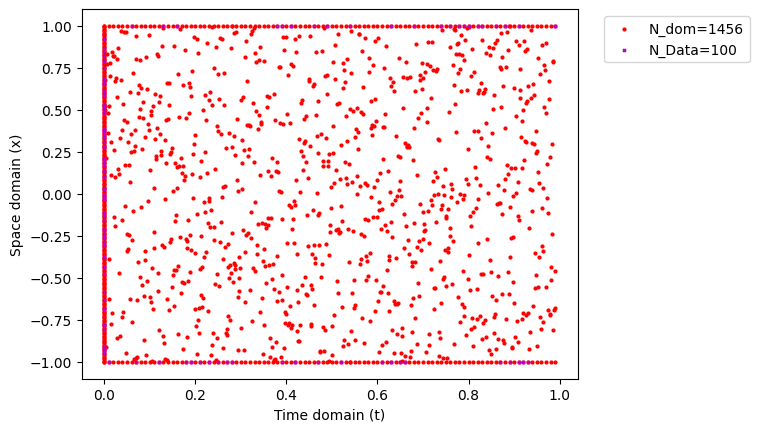

In [ ]:
plotDatasets(datasets)

# Initialization

In [ ]:
 # Neural Network
class PINN_Module(nn.Module):

    def __init__(self, model_parameters):
        super(PINN_Module, self).__init__()
        self.Device = model_parameters["Device"]
        self.LowerBounds = model_parameters["LowerBounds"]
        self.UpperBounds = model_parameters["UpperBounds"]
        self.Viscosity = model_parameters["Viscosity"]
        self.InputDimensions = model_parameters["InputDimensions"]
        self.OutputDimensions = model_parameters["OutputDimensions"]
        self.NumberOfNeurons = model_parameters["NumberOfNeurons"]
        self.NumberOfHiddenLayers = model_parameters["NumberOfHiddenLayers"]
        self.ActivationFunction = model_parameters["ActivationFunction"]
        self.InputLayer = nn.Linear(self.InputDimensions, self.NumberOfNeurons)
        self.HiddenLayers = nn.ModuleList(
            [nn.Linear(self.NumberOfNeurons, self.NumberOfNeurons) for _ in range(self.NumberOfHiddenLayers - 1)])
        self.OutputLayer = nn.Linear(self.NumberOfNeurons, self.OutputDimensions)


    def forward(self, x):
        lb = self.LowerBounds
        ub = self.UpperBounds
        x = 2*(x - lb)/(ub - lb) - 1
        output = self.ActivationFunction(self.InputLayer(x))
        for k, l in enumerate(self.HiddenLayers):
            output = self.ActivationFunction(l(output))
        output = self.OutputLayer(output)
        return output

    def governingEquationResidue(self, X, u):
        nu = self.Viscosity

        # Compute the derivatives of the output w.r.t. the inputs (space and time) using AD mechanism:
        diff_u = torch.autograd.grad(u, X, create_graph=True, grad_outputs=torch.ones_like(u))[0]
        u_x, u_t = diff_u[:, 0:1], diff_u[:, 1:2]

        # Compute the second derivative of the output w.r.t. space using AD mechanism:
        u_xx = torch.autograd.grad(u_x, X, create_graph=True, grad_outputs=torch.ones_like(u))[0][:, 0:1]

        residue = u_t + u*u_x - nu*u_xx
        return residue

In [ ]:
def init_xavier(model):
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            # gain = nn.init.calculate_gain('tanh')
            gain = 1
            torch.nn.init.xavier_uniform_(m.weight, gain=gain)
            torch.nn.init.uniform_(m.bias, 0, 1)

    model.apply(init_weights)

In [ ]:
# Input dictionary for model instance
model_parameters = {
    "Device": device,
    "LowerBounds": lb.to(device),
    "UpperBounds": ub.to(device),
    "Viscosity": 0.01/np.pi, #0.001, # (N.s.m^-2)
    "InputDimensions": 2,
    "OutputDimensions": 1,
    "NumberOfNeurons": 20,
    "NumberOfHiddenLayers": 8,
    "ActivationFunction": nn.Tanh()
}

# Main execution under RAR-G strategy

## Train loop

In [ ]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [ ]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Initialization of data structures
epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = []
loss_train_dom = []
loss_train_data = []
train_keys = ['Overall', 'PDE', 'Data']
X_pde = (datasets['PDE'].X).to(device)
add_samples = 0
n_samples = 10

# Training loop
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        if tag=='PDE':
            if epoch % 1000 == 0 and epoch!=0:
                X = (lb + (ub - lb)*torch.rand(N_dom, 2)).to(device)
                X.requires_grad = True
                T = model(X)
                y_hat = model.governingEquationResidue(X, T)
                idx = torch.topk(y_hat.flatten(), n_samples, dim=0)[1]
                X_pde = torch.cat([X_pde.detach(), X[idx, :].detach()], axis=0)
                add_samples += n_samples

            X_pde.requires_grad = True
            u = model(X_pde)
            y_hat = model.governingEquationResidue(X_pde, u)
            loss = loss_fn(y_hat, torch.zeros_like(y_hat))
            loss_list.append(loss)

        else:
            X = (datasets[tag].X).to(device)
            y = (datasets[tag].y).to(device)
            u = model(X)
            loss = loss_fn(u, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    if isData:
        loss_train_data.append(loss_list[2].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)


elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

##TRAIN## Adam - Epoch: 0, Overall: 3.14995e-01, PDE: 2.81339e-03, Data: 3.12181e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.64383e-01, PDE: 8.09364e-04, Data: 2.63574e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 2.47607e-01, PDE: 2.92769e-03, Data: 2.44680e-01, 
##TRAIN## Adam - Epoch: 300, Overall: 2.22708e-01, PDE: 5.56564e-03, Data: 2.17142e-01, 
##TRAIN## Adam - Epoch: 400, Overall: 2.14578e-01, PDE: 7.96136e-03, Data: 2.06617e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 2.05116e-01, PDE: 9.93507e-03, Data: 1.95180e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 1.50558e-01, PDE: 1.05303e-02, Data: 1.40027e-01, 
##TRAIN## Adam - Epoch: 700, Overall: 1.06521e-01, PDE: 2.35655e-02, Data: 8.29550e-02, 
##TRAIN## Adam - Epoch: 800, Overall: 9.48281e-02, PDE: 2.65663e-02, Data: 6.82618e-02, 
##TRAIN## Adam - Epoch: 900, Overall: 8.93223e-02, PDE: 2.72570e-02, Data: 6.20653e-02, 
##TRAIN## Adam - Epoch: 1000, Overall: 8.70781e-02, PDE: 2.77808e-02, Data: 5.92972e-02, 
##TRAIN## Adam - Epoch

## Loss functions

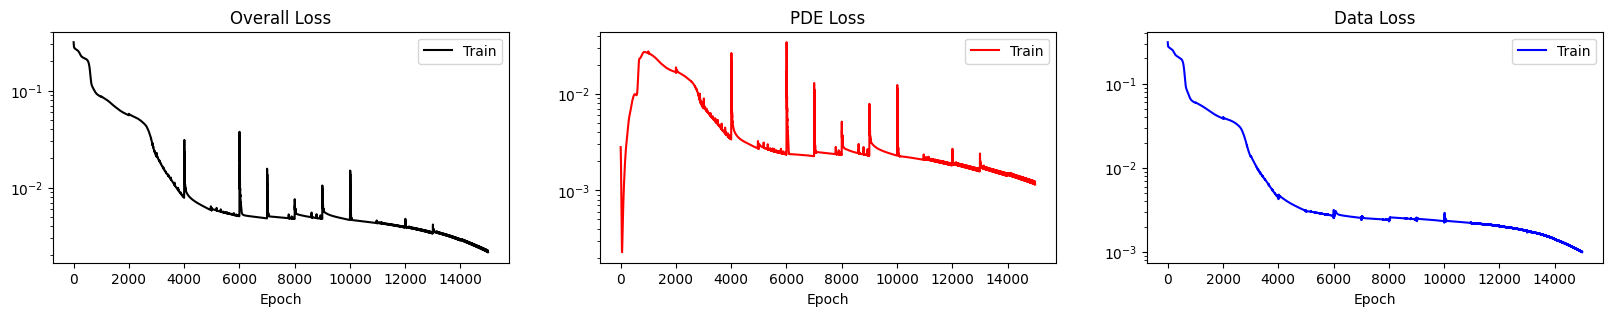

In [ ]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom] #, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss'] #, 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Final dataset

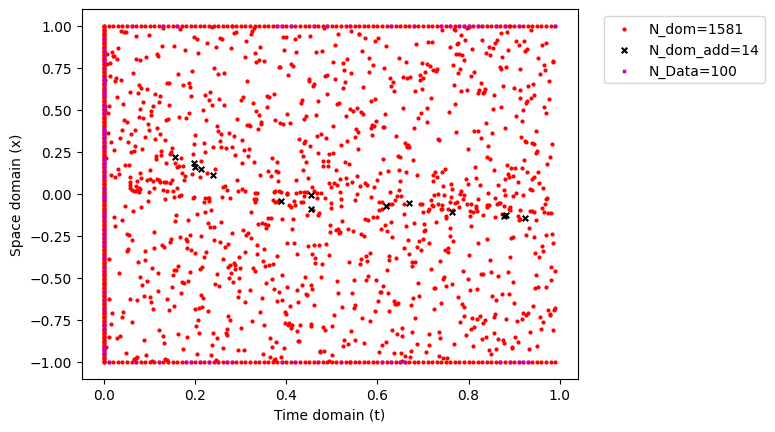

In [ ]:
plotDatasets(datasets, 'RAR-G', X_pde, add_samples)

## Prediction

In [ ]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [ ]:
X_pred = torch.from_numpy(X_star).to(torch.float).to(device)
u_pred = model(X_pred).data.cpu().numpy()
X, T = np.meshgrid(x, t)

#X_star_tensor = tf.convert_to_tensor(X_star, dtype=tf.float32)
#u_pred = predict(X_star_tensor)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 4.015811e-01


Text(0.5, 1.0, '$t = 0.75$')

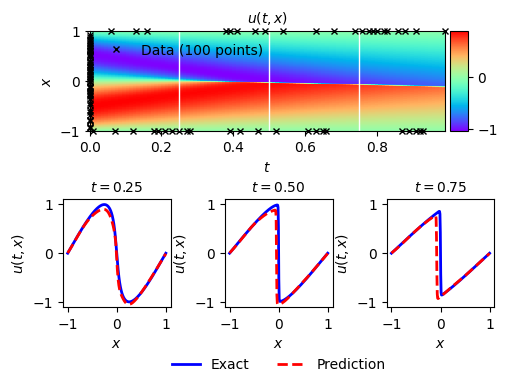

In [ ]:
fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_data[:,1], X_data[:,0], 'kx', label = 'Data (%d points)' % (y_data.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.75$', fontsize = 10)

# Main execution under RAD strategy

## Train loop

In [ ]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [ ]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Initialization of data structures
epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = []
loss_train_dom = []
loss_train_data = []
train_keys = ['Overall', 'PDE', 'Data']
X_pde = (datasets['PDE'].X).to(device)

# Hyperparameters of RAD
k = 1; c = 1

# Training loop
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        if tag=='PDE':
            if epoch % 1000 == 0 and epoch!=0:
                X = (lb + (ub - lb)*torch.rand(10000, 2)).to(device)
                X.requires_grad = True
                T = model(X)
                y_hat = torch.abs(model.governingEquationResidue(X, T))
                err_eq = torch.pow(y_hat, k)/torch.pow(y_hat, k).mean() + c
                err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
                idx = np.random.choice(a=len(X), size=N_dom, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
                X_pde = X[idx.flatten(), :].detach()

            X_pde.requires_grad = True
            u = model(X_pde)
            y_hat = model.governingEquationResidue(X_pde, u)
            loss = loss_fn(y_hat, torch.zeros_like(y_hat))
            loss_list.append(loss)

        else:
            X = (datasets[tag].X).to(device)
            y = (datasets[tag].y).to(device)
            u = model(X)
            loss = loss_fn(u, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    if isData:
        loss_train_data.append(loss_list[2].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)


elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

##TRAIN## Adam - Epoch: 0, Overall: 3.14995e-01, PDE: 2.81339e-03, Data: 3.12181e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.64383e-01, PDE: 8.09364e-04, Data: 2.63574e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 2.47607e-01, PDE: 2.92769e-03, Data: 2.44680e-01, 
##TRAIN## Adam - Epoch: 300, Overall: 2.22708e-01, PDE: 5.56564e-03, Data: 2.17142e-01, 
##TRAIN## Adam - Epoch: 400, Overall: 2.14578e-01, PDE: 7.96136e-03, Data: 2.06617e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 2.05116e-01, PDE: 9.93507e-03, Data: 1.95180e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 1.50558e-01, PDE: 1.05303e-02, Data: 1.40027e-01, 
##TRAIN## Adam - Epoch: 700, Overall: 1.06521e-01, PDE: 2.35655e-02, Data: 8.29550e-02, 
##TRAIN## Adam - Epoch: 800, Overall: 9.48281e-02, PDE: 2.65663e-02, Data: 6.82618e-02, 
##TRAIN## Adam - Epoch: 900, Overall: 8.93223e-02, PDE: 2.72570e-02, Data: 6.20653e-02, 
##TRAIN## Adam - Epoch: 1000, Overall: 1.10270e-01, PDE: 5.09728e-02, Data: 5.92972e-02, 
##TRAIN## Adam - Epoch

## Loss functions

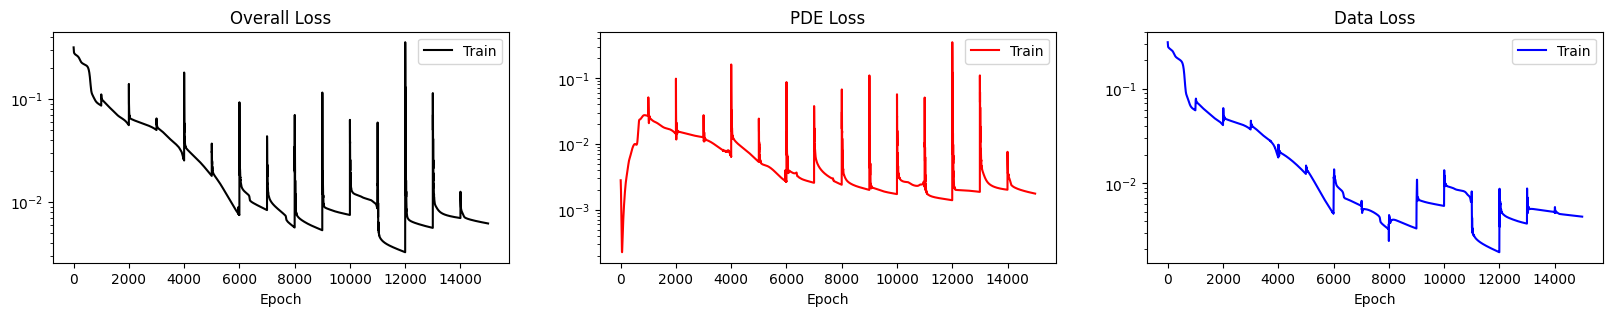

In [ ]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom] #, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss'] #, 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Final dataset

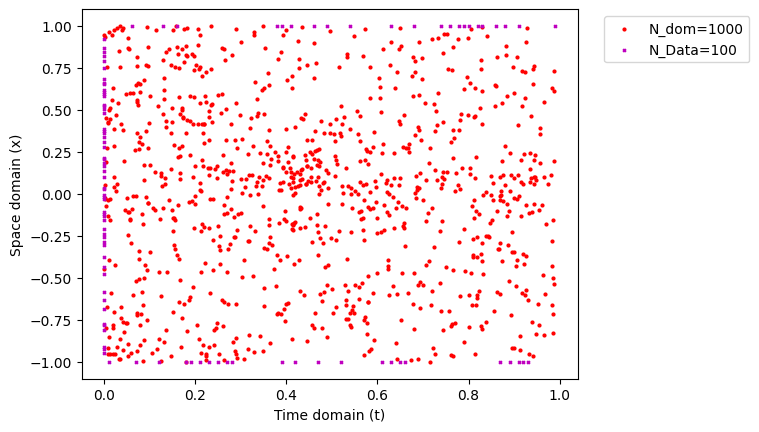

In [ ]:
plotDatasets(datasets, 'RAD', X_pde)

## Prediction

In [ ]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [ ]:
X_pred = torch.from_numpy(X_star).to(torch.float).to(device)
u_pred = model(X_pred).data.cpu().numpy()
X, T = np.meshgrid(x, t)

#X_star_tensor = tf.convert_to_tensor(X_star, dtype=tf.float32)
#u_pred = predict(X_star_tensor)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 4.304923e-01


Text(0.5, 1.0, '$t = 0.75$')

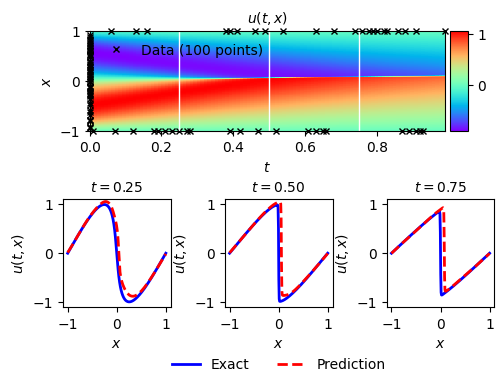

In [ ]:
fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_data[:,1], X_data[:,0], 'kx', label = 'Data (%d points)' % (y_data.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.75$', fontsize = 10)

# Main execution under RAR-D strategy

## Train loop

In [ ]:
# Model construction
torch.manual_seed(10)
model = PINN_Module(model_parameters).to(device)
init_xavier(model)

In [ ]:
# Fitting stage
t0 = datetime.now()
data_time_now = datetime.now().strftime("%d%m%Y_%H%M%S")

# Initialization of data structures
epochs = 15000
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
loss_train = []
loss_train_dom = []
loss_train_data = []
train_keys = ['Overall', 'PDE', 'Data']
X_pde = (datasets['PDE'].X).to(device)

# Hyperparameters of RAD
k = 2; c = 0
add_samples = 0
n_samples = 10

# Training loop
for epoch in range(epochs):
    loss_list = []
    optimizer.zero_grad()
    for tag in tags:
        if tag=='PDE':
            if epoch % 1000 == 0 and epoch!=0:
                X = (lb + (ub - lb)*torch.rand(10000, 2)).to(device)
                X.requires_grad = True
                T = model(X)
                y_hat = torch.abs(model.governingEquationResidue(X, T))
                err_eq = torch.pow(y_hat, k)/torch.pow(y_hat, k).mean() + c
                err_eq_normalized = (err_eq/sum(err_eq))[:, 0]
                idx = np.random.choice(a=len(X), size=n_samples, replace=False, p=err_eq_normalized.data.cpu().detach().numpy())
                X_pde = torch.cat([X_pde.detach(), X[idx.flatten(), :].detach()], axis=0)
                add_samples += n_samples

            X_pde.requires_grad = True
            u = model(X_pde)
            y_hat = model.governingEquationResidue(X_pde, u)
            loss = loss_fn(y_hat, torch.zeros_like(y_hat))
            loss_list.append(loss)

        else:
            X = (datasets[tag].X).to(device)
            y = (datasets[tag].y).to(device)
            u = model(X)
            loss = loss_fn(u, y)
            loss_list.append(loss)

    loss = sum(loss_list)
    loss.backward()
    optimizer.step()

    loss_list.insert(0, loss)
    loss_train.append(loss_list[0].item())
    loss_train_dom.append(loss_list[1].item())
    if isData:
        loss_train_data.append(loss_list[2].item())

    if epoch % 100 == 0:
        log_dict = dict(zip(train_keys, loss_list))
        aux = "".join(f"{key}: {value:.5e}, " for key, value in log_dict.items())
        optimizer_str = type(optimizer).__name__
        print(f"##TRAIN## {optimizer_str} - Epoch: {epoch}, " + aux)


elapsed_time_train = datetime.now() - t0
print("\nTraining Time: ", elapsed_time_train.seconds, "[s]")

##TRAIN## Adam - Epoch: 0, Overall: 3.14995e-01, PDE: 2.81339e-03, Data: 3.12181e-01, 
##TRAIN## Adam - Epoch: 100, Overall: 2.64383e-01, PDE: 8.09364e-04, Data: 2.63574e-01, 
##TRAIN## Adam - Epoch: 200, Overall: 2.47607e-01, PDE: 2.92769e-03, Data: 2.44680e-01, 
##TRAIN## Adam - Epoch: 300, Overall: 2.22708e-01, PDE: 5.56564e-03, Data: 2.17142e-01, 
##TRAIN## Adam - Epoch: 400, Overall: 2.14578e-01, PDE: 7.96136e-03, Data: 2.06617e-01, 
##TRAIN## Adam - Epoch: 500, Overall: 2.05116e-01, PDE: 9.93507e-03, Data: 1.95180e-01, 
##TRAIN## Adam - Epoch: 600, Overall: 1.50558e-01, PDE: 1.05303e-02, Data: 1.40027e-01, 
##TRAIN## Adam - Epoch: 700, Overall: 1.06521e-01, PDE: 2.35655e-02, Data: 8.29550e-02, 
##TRAIN## Adam - Epoch: 800, Overall: 9.48281e-02, PDE: 2.65663e-02, Data: 6.82618e-02, 
##TRAIN## Adam - Epoch: 900, Overall: 8.93223e-02, PDE: 2.72570e-02, Data: 6.20653e-02, 
##TRAIN## Adam - Epoch: 1000, Overall: 8.64119e-02, PDE: 2.71146e-02, Data: 5.92972e-02, 
##TRAIN## Adam - Epoch

## Loss functions

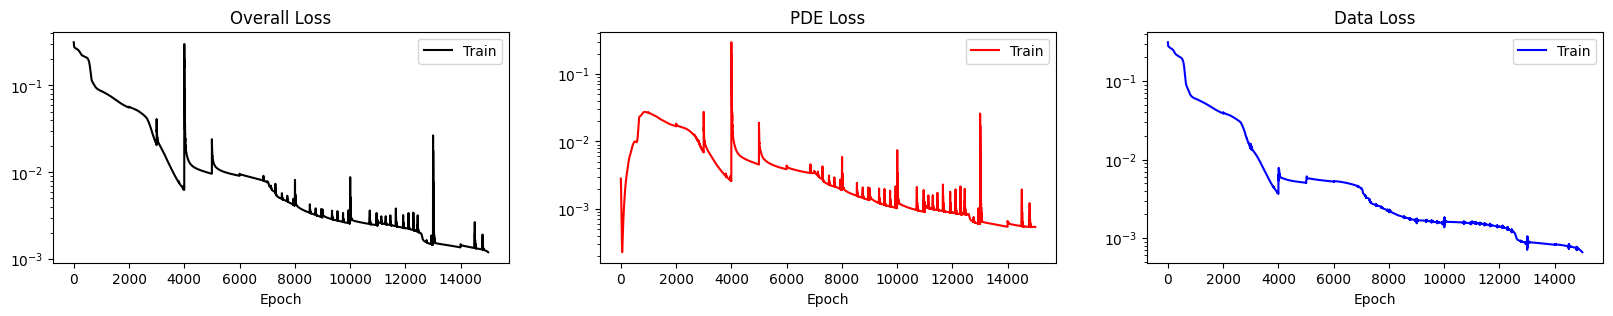

In [ ]:
# Evolution of the loss function
loss_train_list = [loss_train, loss_train_dom] #, loss_train_bc, loss_train_ic]
colors = ['black', 'red', 'blue', 'green']
titles = ['Overall Loss', 'PDE Loss'] #, 'BC Loss', 'IC Loss']
if isData:
    loss_train_list.append(loss_train_data)
    colors.append('magenta')
    titles.append('Data Loss')

fig, ax = plt.subplots(1, len(loss_train_list), figsize=(20, 3))
for i in range(len(loss_train_list)):
    epochs_train = np.arange(0, len(loss_train_list[i]))
    ax[i].semilogy(epochs_train, loss_train_list[i], color=colors[i], label='Train')
    ax[i].set_xlabel('Epoch')
    ax[i].set_title(titles[i])
    ax[i].legend()
plt.show()

## Final dataset

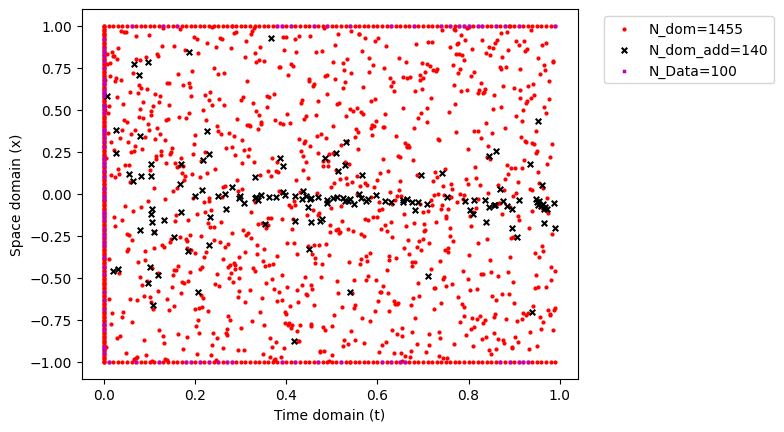

In [ ]:
plotDatasets(datasets, 'RAR-D', X_pde, add_samples)

## Prediction

In [ ]:
def figsize(scale, nplots = 1):
    fig_width_pt = 390.0                          # Get this from LaTeX using \the\textwidth
    inches_per_pt = 1.0/72.27                       # Convert pt to inch
    golden_mean = (np.sqrt(5.0)-1.0)/2.0            # Aesthetic ratio (you could change this)
    fig_width = fig_width_pt*inches_per_pt*scale    # width in inches
    fig_height = nplots*fig_width*golden_mean              # height in inches
    fig_size = [fig_width,fig_height]
    return fig_size

def newfig(width, nplots = 1):
    fig = plt.figure(figsize=figsize(width, nplots))
    ax = fig.add_subplot(111)
    return fig, ax

def savefig(filename, crop = True):
    if crop == True:
#        plt.savefig('{}.pgf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.pdf'.format(filename), bbox_inches='tight', pad_inches=0)
        plt.savefig('{}.eps'.format(filename), bbox_inches='tight', pad_inches=0)
    else:
#        plt.savefig('{}.pgf'.format(filename))
        plt.savefig('{}.pdf'.format(filename))
        plt.savefig('{}.eps'.format(filename))

In [ ]:
X_pred = torch.from_numpy(X_star).to(torch.float).to(device)
u_pred = model(X_pred).data.cpu().numpy()
X, T = np.meshgrid(x, t)

#X_star_tensor = tf.convert_to_tensor(X_star, dtype=tf.float32)
#u_pred = predict(X_star_tensor)
error_u = np.linalg.norm(u_star-u_pred,2)/np.linalg.norm(u_star,2)
print('Error u: %e' %(error_u))
U_pred = griddata(X_star, u_pred.flatten(), (X, T), method='cubic')
Error = 100* np.linalg.norm(Exact - U_pred) / np.linalg.norm(U_pred)

Error u: 2.164758e-01


Text(0.5, 1.0, '$t = 0.75$')

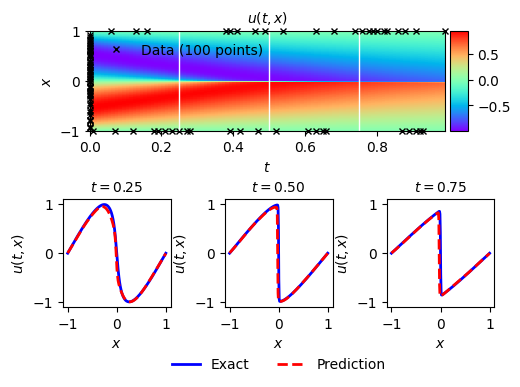

In [ ]:
fig, ax = newfig(1.0, 1.1)
ax.axis('off')

####### Row 0: u(t,x) ##################
gs0 = gridspec.GridSpec(1, 2)
gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
ax = plt.subplot(gs0[:, :])

h = ax.imshow(U_pred.T, interpolation='nearest', cmap='rainbow',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.plot(X_data[:,1], X_data[:,0], 'kx', label = 'Data (%d points)' % (y_data.shape[0]), markersize = 4, clip_on = False)
#ax.plot(X_f_train[0:100,1], X_f_train[0:100,0], 'bx', label = 'Data (%d points)' % (u_train.shape[0]), markersize = 4, clip_on = False)


line = np.linspace(x.min(), x.max(), 2)[:,None]
ax.plot(t[25]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[50]*np.ones((2,1)), line, 'w-', linewidth = 1)
ax.plot(t[75]*np.ones((2,1)), line, 'w-', linewidth = 1)

ax.set_xlabel('$t$')
ax.set_ylabel('$x$')
ax.legend(frameon=False, loc = 'best')
ax.set_title('$u(t,x)$', fontsize = 10)

####### Row 1: u(t,x) slices ##################
gs1 = gridspec.GridSpec(1, 3)
gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)

ax = plt.subplot(gs1[0, 0])
ax.plot(x,Exact[25,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[25,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.set_title('$t = 0.25$', fontsize = 10)
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])

ax = plt.subplot(gs1[0, 1])
ax.plot(x,Exact[50,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[50,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.50$', fontsize = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)

ax = plt.subplot(gs1[0, 2])
ax.plot(x,Exact[75,:], 'b-', linewidth = 2, label = 'Exact')
ax.plot(x,U_pred[75,:], 'r--', linewidth = 2, label = 'Prediction')
ax.set_xlabel('$x$')
ax.set_ylabel('$u(t,x)$')
ax.axis('square')
ax.set_xlim([-1.1,1.1])
ax.set_ylim([-1.1,1.1])
ax.set_title('$t = 0.75$', fontsize = 10)